# Correlations are ruining your gradient descent

This codebase is intended to accompany the paper which can be viewed at: https://arxiv.org/abs/2407.10780

This notebook is a simple example of how to integrate the decorrelation layers which I provide into an arbitrary neural network with linear and convolutional layers.
All code is provided for the PyTorch framework.


**Author: Nasir Ahmad (02/10/2024)**

In [1]:
import torch
from decor import DecorLinear, DecorConv2d
import torchvision
from torchvision.transforms import v2
from utils import train, test, construct_dataloaders
import matplotlib.pyplot as plt
device = "cuda" if torch.cuda.is_available() else "cpu"


## Composing a fully-connected network with decorrelation

In general, one might compose a model via a `torch.nn.Module` or simply by composing a set of layers as shown in the example below.

In [2]:
model = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(32*32*3, 256),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(256, 256),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(256, 10),
)

One may then train this model on a dataset, such as the CIFAR10 image dataset.

In [3]:
train_loader, valid_loader = construct_dataloaders(
    tv_dataset=torchvision.datasets.CIFAR10,
    batch_size=256,
    validation=True,
    device=device,
)

def train_test_loop(model, train_loader, valid_loader, optimizer, loss_function):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()

        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = loss_function(output, target)
        loss.backward()

        optimizer.step()
    
    model.eval()
    total_loss = 0
    total_acc = 0
    for batch_idx, (data, target) in enumerate(valid_loader):
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = loss_function(output, target)
        total_loss += loss.item()

        pred = output.argmax(dim=1, keepdim=True)
        total_acc += pred.eq(target.view_as(pred)).sum().item()
    
    return total_loss / len(valid_loader.dataset), total_acc / len(valid_loader.dataset)

/home/nasahm/miniconda3/envs/perturbatorch/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


Files already downloaded and verified


In [4]:
num_epochs = 5
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_function = torch.nn.CrossEntropyLoss()
model.to(device)
model_valid_acc = []

for e in range(num_epochs):
    valid_loss, valid_acc = train_test_loop(model, train_loader, valid_loader, optimizer, loss_function)
    
    model_valid_acc.append(valid_acc)
    print(f"Epoch {e+1}/{num_epochs}, Loss: {valid_loss}, Accuracy: {valid_acc}")

Epoch 1/5, Loss: 0.0067410166144371035, Accuracy: 0.393
Epoch 2/5, Loss: 0.006530230295658111, Accuracy: 0.4134
Epoch 3/5, Loss: 0.006355533790588379, Accuracy: 0.4299
Epoch 4/5, Loss: 0.006189989793300629, Accuracy: 0.4419
Epoch 5/5, Loss: 0.006011791944503784, Accuracy: 0.4514


#### Adding Decorrelation
To add decorrelation, we have created two wrappers, `DecorLinear` and `DecorConv2D` which are designed to be able to wrap `torch.nn.Linear` or `torch.nn.Conv2D` respectively. Below is an example of how to use this in our previousy created model

In [5]:
decor_model = torch.nn.Sequential(
    torch.nn.Flatten(),
    DecorLinear(torch.nn.Linear, 32*32*3, 256, decor_lr=1e-5),
    torch.nn.LeakyReLU(),
    DecorLinear(torch.nn.Linear, 256, 256, decor_lr=1e-5),
    torch.nn.LeakyReLU(),
    DecorLinear(torch.nn.Linear, 256, 10, decor_lr=1e-5),
)

In [6]:
num_epochs = 5
optimizer = torch.optim.Adam(decor_model.parameters(), lr=1e-3)
loss_function = torch.nn.CrossEntropyLoss()
decor_model.to(device)
decor_model_valid_acc = []

for e in range(num_epochs):
    valid_loss, valid_acc = train_test_loop(decor_model, train_loader, valid_loader, optimizer, loss_function)
    
    decor_model_valid_acc.append(valid_acc)
    print(f"Epoch {e+1}/{num_epochs}, Loss: {valid_loss}, Accuracy: {valid_acc}")

Epoch 1/5, Loss: 0.006608121657371521, Accuracy: 0.4068
Epoch 2/5, Loss: 0.006180898106098175, Accuracy: 0.4346
Epoch 3/5, Loss: 0.00604883189201355, Accuracy: 0.4592
Epoch 4/5, Loss: 0.005885949289798737, Accuracy: 0.4729
Epoch 5/5, Loss: 0.00577430727481842, Accuracy: 0.4764


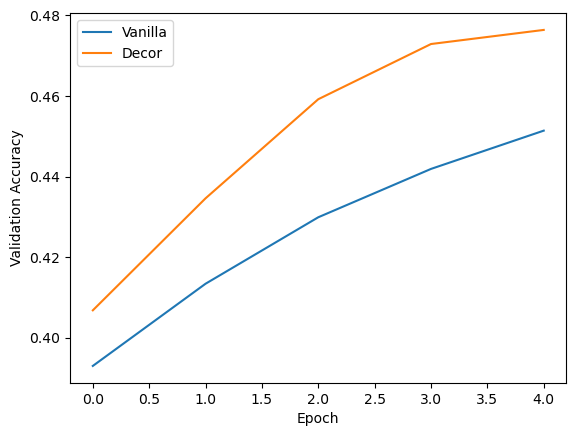

In [7]:
plt.plot(model_valid_acc, label="Vanilla")
plt.plot(decor_model_valid_acc, label="Decor")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.legend()
plt.show()

## Composing a convolutional network with decorrelation
In a similar style to the above, we can compose a convolutional network with decorrelation layers.

In [10]:
regular_conv_model = torch.nn.Sequential(
    torch.nn.Conv2d(3, 32, 3, padding=1, stride=2),
    torch.nn.LeakyReLU(),
    torch.nn.Conv2d(32, 64, 3, padding=1, stride=2),
    torch.nn.LeakyReLU(),
    torch.nn.Flatten(),
    torch.nn.Linear(64*8*8, 256),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(256, 10),
)

decor_conv_model = torch.nn.Sequential(
    DecorConv2d(torch.nn.Conv2d, 3, 32, 3, padding=1, stride=2),
    torch.nn.LeakyReLU(),
    DecorConv2d(torch.nn.Conv2d, 32, 64, 3, padding=1, stride=2),
    torch.nn.LeakyReLU(),
    torch.nn.Flatten(),
    DecorLinear(torch.nn.Linear, 64*8*8, 256),
    torch.nn.LeakyReLU(),
    DecorLinear(torch.nn.Linear, 256, 10),
)

In [11]:
num_epochs = 5

regular_optimizer = torch.optim.Adam(regular_conv_model.parameters(), lr=1e-3)
decor_optimizer = torch.optim.Adam(decor_conv_model.parameters(), lr=1e-3)

regular_conv_model.to(device)
decor_conv_model.to(device)

decor_model_valid_acc = []
regular_model_valid_acc = []

loss_function = torch.nn.CrossEntropyLoss()

for e in range(num_epochs):
    regular_valid_loss, regular_valid_acc = train_test_loop(regular_conv_model, train_loader, valid_loader, regular_optimizer, loss_function)
    decor_valid_loss, decor_valid_acc = train_test_loop(decor_conv_model, train_loader, valid_loader, decor_optimizer, loss_function)


    decor_model_valid_acc.append(decor_valid_acc)
    regular_model_valid_acc.append(regular_valid_acc)
    print(f"Epoch {e+1}/{num_epochs}, Regular Conv Accuracy: {regular_valid_acc}, Decor Conv Accuracy: {decor_valid_acc}")

Epoch 1/5, Regular Conv Accuracy: 0.4606, Decor Conv Accuracy: 0.5135
Epoch 2/5, Regular Conv Accuracy: 0.5027, Decor Conv Accuracy: 0.5692
Epoch 3/5, Regular Conv Accuracy: 0.5455, Decor Conv Accuracy: 0.6085
Epoch 4/5, Regular Conv Accuracy: 0.5751, Decor Conv Accuracy: 0.6365
Epoch 5/5, Regular Conv Accuracy: 0.5931, Decor Conv Accuracy: 0.647


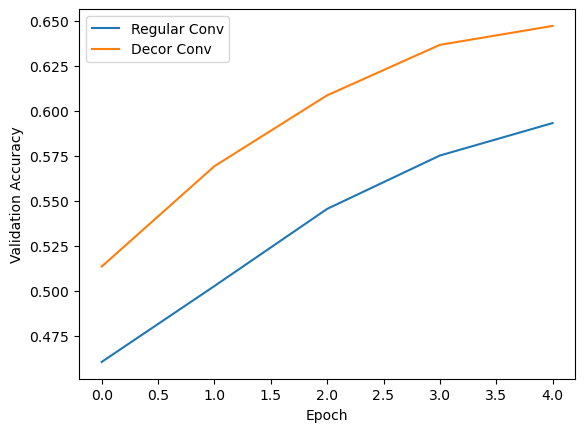

In [12]:
plt.plot(regular_model_valid_acc, label="Regular Conv")
plt.plot(decor_model_valid_acc, label="Decor Conv") 
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.legend()
plt.show()

This concludes a short demonstration of how to use the decorrelation functions in this repository. If there are further questions/queries, feel free to post in the repository or send to `nasir.ahmad[at]donders.ru.nl`

To run the specific experiments in the original paper, see the `run.py` and `conf/config.yaml` files.